<a href="https://colab.research.google.com/github/jjyjung/ai/blob/gh-pages/tf_keras_CNN_CU200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')   # google drive를 google colab에 연결. 처음 실행 시, 인증 필요 

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/ai/CUB200.zip' -d '/content/gdrive/My Drive/Colab Notebooks/ai/CUB200'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0012_27062.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0013_27110.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0016_27181.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0021_797286.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0024_27057.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0027_27153.jpg  
  inflating: /content/gdrive/My Drive/Colab Notebooks/ai/CUB200/train/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0030_27

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
import os

dir = "/content/gdrive/My Drive/Colab Notebooks/ai/"
train_folder = dir + 'CUB200/train'
test_folder = dir + 'CUB200/test'

class_reduce=0.1 # 부류 수 줄여서 데이터양 줄임(속도와 메모리 효율을 위해)
no_class=int(len(os.listdir(train_folder))*class_reduce) # 부류 개수

x_train,y_train=[],[]
for i,class_name in enumerate(os.listdir(train_folder)):
    if i<no_class: # 13~14행이 지정한 부류만 사용
        for fname in os.listdir(train_folder+'/'+class_name):
            img=image.load_img(train_folder+'/'+class_name+'/'+fname,target_size=(224,224))
            if len(img.getbands())!=3:
                print("주의: 유효하지 않은 영상 발생",class_name,fname)
                continue
            x=image.img_to_array(img)
            x=preprocess_input(x)
            x_train.append(x)
            y_train.append(i)

x_test,y_test=[],[]
for i,class_name in enumerate(os.listdir(test_folder)):
    if i<no_class: # 13~14행이 지정한 부류만 사용
        for fname in os.listdir(test_folder+'/'+class_name):
            img=image.load_img(test_folder+'/'+class_name+'/'+fname,target_size=(224,224))
            if len(img.getbands())!=3:
                print("주의: 유효하지 않은 영상 발생",class_name,fname)
                continue
            x=image.img_to_array(img)
            x=preprocess_input(x)
            x_test.append(x)
            y_test.append(i)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
y_train=tf.keras.utils.to_categorical(y_train,no_class)
y_test=tf.keras.utils.to_categorical(y_test,no_class)

# Transfer Learning 부분
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
cnn=Sequential()
cnn.add(base_model)
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(no_class,activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1024)              102761472 
                                                                 
 dense_5 (Dense)             (None, 20)                20500     
                                                                 
Total params: 126,369,684
Trainable params: 126,316,564
Non-trainable params: 53,120
_________________________________________________________________


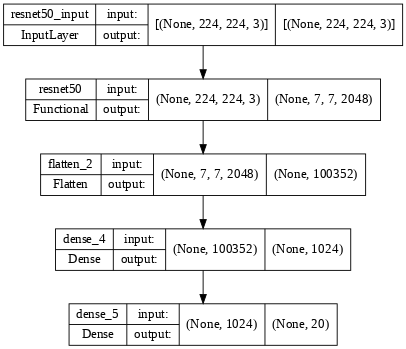

In [ ]:
# 모델 확인
cnn.summary()

# SVG로 그리기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
%matplotlib inline
SVG(model_to_dot(cnn, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(cnn, to_file=dir+'cnn_resnet.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

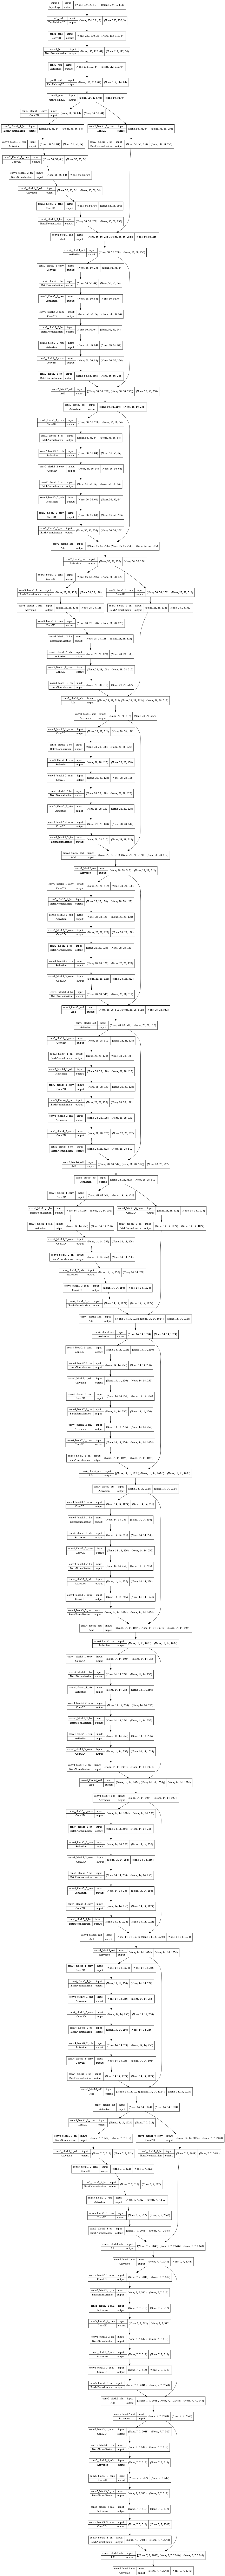

In [ ]:
# Transfer Learning 부분
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

# 모델 확인
base_model.summary()

# SVG로 그리기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
%matplotlib inline
SVG(model_to_dot(base_model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(base_model, to_file=dir+'cnn_resnet.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

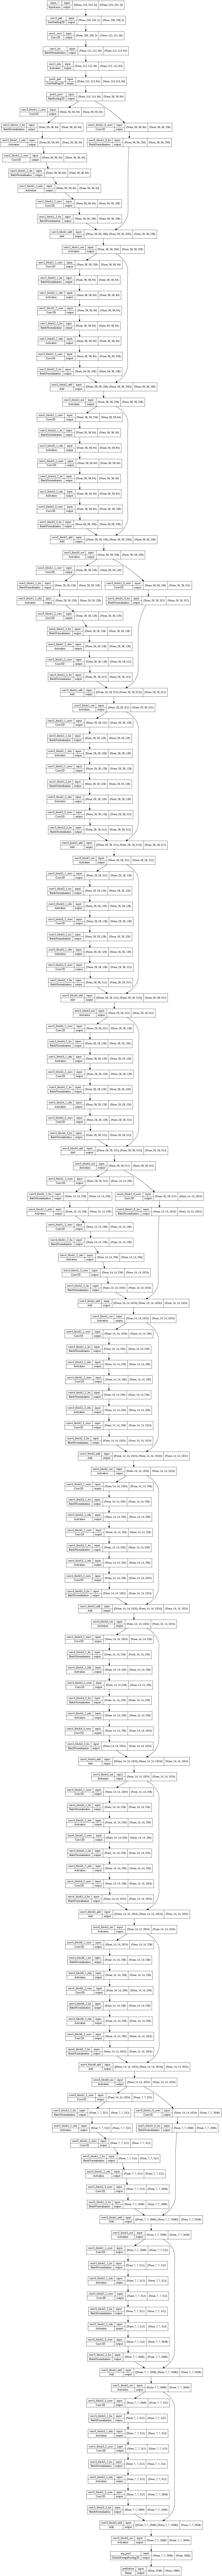

In [ ]:
# Transfer Learning 부분
base_model_T=ResNet50(weights='imagenet',include_top=True,input_shape=(224,224,3))

# 모델 확인
base_model_T.summary()

# SVG로 그리기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
%matplotlib inline
SVG(model_to_dot(base_model_T, show_shapes=True, dpi=65).create(prog='dot', format='svg'))  # SVG로 가시화
plot_model(base_model_T, to_file=dir+'cnn_resnet.png', show_shapes=True, show_layer_names=True, dpi=65) # 파일 출력

In [8]:
import matplotlib.pyplot as plt

def draw_plot(hist):
  # 정확률 그래프
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.grid()
  plt.show()

  # 손실 함수 그래프
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.grid()
  plt.show()

Epoch 1/30
100/100 [==============================] - 18s 132ms/step - loss: 1.6997 - accuracy: 0.5400 - val_loss: 1.1856 - val_accuracy: 0.6485
Epoch 2/30
100/100 [==============================] - 12s 123ms/step - loss: 0.0260 - accuracy: 0.9950 - val_loss: 1.0980 - val_accuracy: 0.6602
Epoch 3/30
100/100 [==============================] - 12s 124ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.0707 - val_accuracy: 0.6874
Epoch 4/30
100/100 [==============================] - 12s 124ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.0481 - val_accuracy: 0.6913
Epoch 5/30
100/100 [==============================] - 12s 123ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.0304 - val_accuracy: 0.6951
Epoch 6/30
100/100 [==============================] - 12s 125ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0250 - val_accuracy: 0.6971
Epoch 7/30
100/100 [==============================] - 12s 125ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.0583 - val_ac

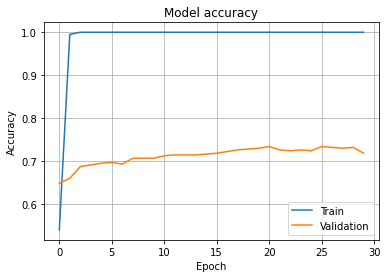

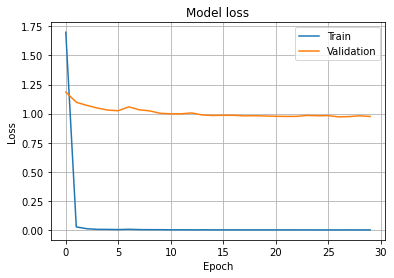

In [13]:
cnn=Sequential()
cnn.add(base_model)
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(no_class,activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode='min')

cnn.compile(loss='categorical_crossentropy',optimizer=Adam(0.00001),metrics=['accuracy'])
hist=cnn.fit(x_train,y_train,batch_size=6,epochs=30,validation_data=(x_test,y_test),
             callbacks=[early_stop],shuffle = True,verbose=1)

res=cnn.evaluate(x_test,y_test,verbose=0)
draw_plot(hist)

In [ ]:
# 테스트 집합
res = cnn.predict(x_test)

# Confusion Matrix
conf=np.zeros((20,20))
for i in range(len(res)):
  conf[res[i].argmax()][y_test[i].argmax()]+=1
print(conf)

# 정확률 계산(2)
no_correct=0
for i in range(20):
  no_correct+=conf[i][i]
accuracy=no_correct/len(res)
print("정확률(%):",accuracy*100)

[[17.  1.  4.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 2. 25.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  1.]
 [ 6.  2. 12.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 21.  0.  0.  0.  0.  1.  0.  4.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  1.  0. 10.  0.  2.  1.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.]
 [ 0.  0.  0.  0.  1.  7.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  1.  0.  2.  3. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 5.  0.  4.  1.  1.  0.  3. 14.  4.  0.  0.  1.  1.  0.  1.  0.  0.  0.
   1.  0.]
 [ 0.  0.  1.  3.  0.  0.  0.  0. 11.  7.  4.  1.  2.  2.  0.  0.  0.  0.
   4.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  0.  0. 20.  3.  1.  0.  0.  0.  0.  1.  0.
   0.  0.]
 [ 0.  1.  0.  2.  0.  0.  0.  0.  4.  0. 14.  0.  1.  0.  1.  0.  1.  0.
   3.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1. 20.  2.  0.  1.  0.